In [1]:
import pandas as pd 

import numpy as np 

import seaborn as sns 

import matplotlib.pyplot as plt 

Import Nina's Data and join all relevant columns to my existing data.

there are concerns that I have miscalculated columns

In [2]:
orig = pd.read_csv('/Users/jack/Desktop/ManhattanProject/ML_dataset.csv').infer_objects()

In [3]:
econ_pop = pd.read_csv('/Users/jack/Desktop/ManhattanProject/3rd party Data/econ_pop.csv').infer_objects()

age_pop = pd.read_csv('/Users/jack/Desktop/ManhattanProject/3rd party Data/age_pop.csv').infer_objects()

In [4]:
#Import Data 

df = pd.read_csv('/Users/jack/Desktop/ManhattanProject/team_data_new.csv',
                 encoding='latin-1').infer_objects()

#convert columns to upper-case

df.columns = df.columns.str.upper()

#drop unnamed column

#df = df.drop('UNNAMED: 0',axis=1)

#inspect data 

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88999 entries, 0 to 88998
Columns: 212 entries, CCN to PROCESSING_DATE
dtypes: float64(165), int64(19), object(28)
memory usage: 143.9+ MB
None


In [5]:
'NET_OPERATING_MARGIN'

'NET_OPERATING_MARGIN'

# merge in 3rd party features 

In [6]:
df = (df.merge(orig[['FIPS','federal_provider_number','fiscal_year']],
          
          
         left_on=['CCN','COST_REPORT_YEAR'],
         
         
         right_on=['federal_provider_number','fiscal_year'])\
             
             
             .merge(age_pop[['FIPS','TimeFrame','perc_eld_pop','old_age_support']]\
                 
                 
                 .set_index(['FIPS','TimeFrame']),left_on=['FIPS','fiscal_year'],
                 
                    right_index=True,
)\
                        .merge(econ_pop[['FIPS','perc_poverty_avg','med_income_avg']],
                               on=['FIPS']))\
                                   .drop(['federal_provider_number','fiscal_year'],axis=1).set_index('FIPS')

dropping some duplicate rows I found. (must be a joining error that wasn't caught when provided the data)

In [7]:
df = df.drop_duplicates(subset=['CCN','COST_REPORT_YEAR','COSTREPORTNUMBER'])

In [8]:
# merge in risk standardized readmission rate 

risk = pd.read_csv('/Users/jack/Desktop/ManhattanProject/CRAY_PIAY_RAD.csv')[['CCN','Cost_Report_Year','Risk_Standardized_Readmission_Rate']]

df = df.merge(risk,left_on=['CCN','COST_REPORT_YEAR'],right_on=['CCN','Cost_Report_Year'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64603 entries, 0 to 64602
Columns: 218 entries, CCN to Risk_Standardized_Readmission_Rate
dtypes: float64(169), int64(21), object(28)
memory usage: 107.4+ MB


# Inspecting and cleaning Nina's Dataset

In [10]:
#df = df.sort_values(by='COST_REPORT_YEAR',ascending=True)

#df.isna().sum().sort_values(ascending=False)[:50] # we realistically can't use columns with over 10k missing values as features.... 

#null_colls = df.isna().sum() >= 20_000

#df.loc[:,null_colls] # inspecting null cols 

#dropping 13 null cols and subsetting for FOR PROFIT homes only. 

#df = df.loc[:,~null_colls]\
    #.query('OWNERSHIP_TYPE == "For Profit "')

we get rid of non-profit/govt nursing homes as they aren't relevant.

In [11]:
#strip whitespace 
df[['OWNERSHIP_TYPE',
    'OWNERSHIP_TYPE_DETAIL']] = df[['OWNERSHIP_TYPE',
                                    'OWNERSHIP_TYPE_DETAIL']].apply(lambda x: x.str.strip())
    
#subset for profit only and filter out covid year of data 

df = df[(df['OWNERSHIP_TYPE'] == "For profit") & (df['COST_REPORT_YEAR'] != 2020)]

#new df shape
df.shape

(48238, 218)

In [12]:

#cats list is categorical columns i am bringing from my dataset, already preprocessed and to avoid some confusion
cats = ['PROVIDER_RESIDES_IN_HOSPITAL',
 'CONTINUING_CARE_RETIREMENT_COMMUNITY',
 'PROVIDER_CHANGED_OWNERSHIP_IN_LAST_12_MONTHS',
 'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_FAMILY',
 'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_RESIDENT',
 'RURAL_VERSUS_URBAN_U',
 'PROVIDER_TYPE_MEDICARE AND MEDICAID']

#convert cats to lowercase to join easier 

cats = [x.lower() for x in cats]

#convert df cols to all lower

orig.columns = orig.columns.str.lower()

#define cols to join 

cols_to_join = ['federal_provider_number','fiscal_year','lat','lng','unemp','pop','facil_start_year']

In [13]:
#merge in some key features (lat, lng, pop, unemp) and drop ID cols to prepare for modeling 

df = df.merge(orig[cols_to_join + cats], # join these as defined above 
         #join cols 
         left_on=['CCN','COST_REPORT_YEAR'],
         #join cols 
         right_on=['federal_provider_number','fiscal_year'],
        how='inner' #inner join
        )\
            .drop(['CCN',
                   'federal_provider_number','fiscal_year'],axis=1) #drop these columns, they're dupes 

# Create financial ratios to reduce dimensionality

In [14]:
df = df.assign(
    # Liquidity Ratios
    Current_Ratio = df['TOTAL_CURRENT_ASSETS'] / df['TOTAL_CURRENT_LIABILITIES'],
    Quick_Ratio = (df['CASH_ON_HAND_AND_IN_BANKS'] + df['ACCOUNTS_RECEIVABLE']) / df['TOTAL_CURRENT_LIABILITIES'],
    
    #avg occupancy ratio 
    occupancy_rate = df['AVERAGE_OCCUPIED_BED_PER_DAY'].div(df['SNF_NUMBER_OF_BEDS']),

    # Debt Ratios
    Debt_to_Equity_Ratio = df['TOTAL_LIABILITIES'] / df['TOTAL_FUND_BALANCES'],
    Debt_Ratio = df['TOTAL_LIABILITIES'] / df['TOTAL_ASSETS'],
    
    #facil age 
    facil_age = df['COST_REPORT_YEAR'] - df['facil_start_year'],
    
    #total incidents 
    total_incidents = df[['NUMBER_OF_FACILITY_REPORTED_INCIDENTS',
       'NUMBER_OF_SUBSTANTIATED_COMPLAINTS',
       'NUMBER_OF_FINES',
       'NUMBER_OF_PAYMENT_DENIALS',
       'TOTAL_NUMBER_OF_PENALTIES']].sum(axis=1),
    total_equipment = df[['FIXED_EQUIPMENT','MAJOR_MOVABLE_EQUIPMENT','LAND','BUILDINGS']].sum(axis=1) #this is PPE, plant, property, equipment
)\
    .drop('facil_start_year',axis=1) # drop un-needed column


# Clean outliers (univariate)

In [15]:
def tukeys_fences(df,col):
    
    lower, upper = df[col].quantile([.25,.75]).values

    iqr = upper - lower 

    lower_lim = lower - iqr * 1.5 

    upper_lim = upper + iqr * 1.5 

    mask = (df[col] > upper_lim) | (df[col] < lower_lim)
    
    print(f'PCT of Outliers Detected in {col}: {mask.sum()/len(df):.3f}%')

    df.loc[mask,col] = np.nan
    
    return df 

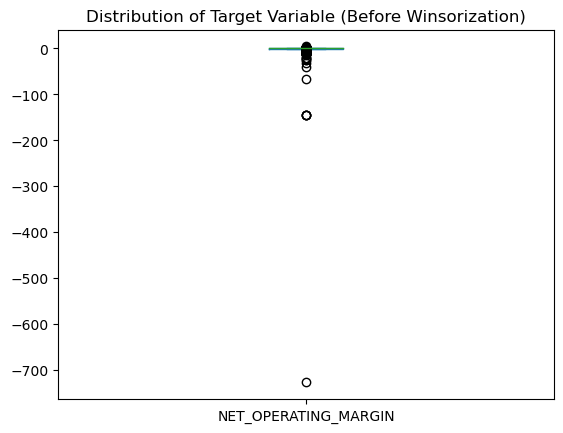

In [16]:
df.NET_OPERATING_MARGIN.plot(kind='box',
                         title='Distribution of Target Variable (Before Winsorization)') # our target contains extreme outliers, lets winsorize, then utilize tukey's fences 


lower = np.percentile(df['NET_OPERATING_MARGIN'],2.5)
          
upper = np.percentile(df['NET_OPERATING_MARGIN'],97.5)

df.loc[(df['NET_OPERATING_MARGIN'] > upper) | (df['NET_OPERATING_MARGIN'] < lower),'NET_OPERATING_MARGIN'] = np.nan  #fill outliers with NAN 

In [17]:
#list of all continuous numerical columns 

num_cols = ['COST_REPORT_YEAR', 
            'TOTAL_ASSETS',
            'TOTAL_LIABILITIES'
 'FISCAL_YEAR_DAYS', 
       'TOTAL_DAYS_TITLE_XVIII', 
       'TOTAL_DAYS_TITLE_XIX', 
       'TOTAL_DAYS_TOTAL', 
       'TOTAL_BED_DAYS_AVAILABLE',
       'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XVIII',
       'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XIX',
       'SNF_AVERAGE_LENGTH_OF_STAY_TOTAL',
       'SNF_ADMISSIONS_TITLE_XVIII',
       'SNF_ADMISSIONS_TITLE_XIX', 
       'SNF_ADMISSIONS_OTHER',
       'SNF_ADMISSIONS_TOTAL',
       'SNF_DAYS_TITLE_XVIII',
       'SNF_DAYS_TITLE_XIX',
       'SNF_DAYS_OTHER', 
       'SNF_DAYS_TOTAL', 
       'SNF_NUMBER_OF_BEDS',
       'SNF_BED_DAYS_AVAILABLE',
       'SNF_DISCHARGES_TITLE_XVIII',
       'SNF_DISCHARGES_TITLE_XIX',
       'SNF_DISCHARGES_TITLE_OTHER',
       'SNF_DISCHARGES_TOTAL',
       'TOTAL_ASSETS',
       'ACCOUNTS_PAYABLE',
       'TOTAL_CURRENT_LIABILITIES', 'TOTAL_LIABILITIES',
       'GENERAL_FUND_BALANCE', 'TOTAL_FUND_BALANCES',
       'TOTAL_LIABILITIES_AND_FUND_BALANCES',
        'TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE',
       'total_incidents',
       'TOTAL_AMOUNT_OF_FINES_IN_DOLLARS',
       'Risk_Standardized_Readmission_Rate',
       'lat', 'lng', 'unemp', 'pop',
      'perc_eld_pop', 
      'old_age_support', 
      'perc_poverty_avg', 
      'med_income_avg',
       'ADJUSTED_TOTAL_NURSE_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
       #financial ratios 
       'NET_OPERATING_MARGIN', #this is our target variable 
       'Current_Ratio',
       'Quick_Ratio', 
       'Debt_to_Equity_Ratio', 
       'Debt_Ratio',
       'occupancy_rate',
       'total_equipment',
       'PERCENT_DAYS_TITLE_XVIII', 
       'PERCENT_DAYS_TITLE_XIX']

# make lists of all continous columns in the dataset and all categorical columns in the dataset

I have already selected these columns from a larger dataset using various feature selection techniques

In [18]:

#all continuous column in dataset
continuous_cols = [#'FISCAL_YEAR_DAYS',
#'TYPE_OF_CONTROL', # this is categorical/nominal
      # 'TOTAL_DAYS_TITLE_XVIII', 
      # 'TOTAL_DAYS_TITLE_XIX',
      # 'TOTAL_DAYS_OTHER',
       'TOTAL_DAYS_TOTAL', 
       #'NUMBER_OF_BEDS',
       'TOTAL_BED_DAYS_AVAILABLE',
      # 'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XVIII',
       #'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XIX',
       'SNF_AVERAGE_LENGTH_OF_STAY_TOTAL', 
       #'SNF_ADMISSIONS_TITLE_XVIII', 
       'SNF_ADMISSIONS_OTHER',
       'SNF_ADMISSIONS_TOTAL', 
       #'SNF_DAYS_TITLE_XVIII',
       #'SNF_DAYS_TITLE_XIX',
       #'SNF_DAYS_OTHER', 
       'SNF_DAYS_TOTAL', 
       'SNF_NUMBER_OF_BEDS',
       'SNF_BED_DAYS_AVAILABLE',
      # 'SNF_DISCHARGES_TITLE_XVIII',
      # 'SNF_DISCHARGES_TITLE_XIX', 
      # 'SNF_DISCHARGES_TITLE_OTHER',
       'SNF_DISCHARGES_TOTAL', 
       #occupancy 
       'occupancy_rate',
       'AVERAGE_OCCUPIED_BED_PER_DAY',
        'TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE',
        #penalties and fines 
      'total_incidents',
       'TOTAL_AMOUNT_OF_FINES_IN_DOLLARS', 
       'Risk_Standardized_Readmission_Rate',
       #economic/location
       'lat', 'lng',
       'unemp', 
       'pop',
        'perc_eld_pop', 
      'old_age_support', 
      'perc_poverty_avg', 
      'med_income_avg',
       #staffing 
      # 'ADJUSTED_NURSE_AIDE_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
      # 'ADJUSTED_LPN_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
      # 'ADJUSTED_RN_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
       'ADJUSTED_TOTAL_NURSE_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
       #target 
       'NET_OPERATING_MARGIN',
       'Current_Ratio',
       'Quick_Ratio', 
       'Debt_to_Equity_Ratio', 
       'Debt_Ratio',
       'total_equipment',
       'TOTAL_ASSETS',
      # 'TOTAL_LIABILITIES',
       'TOTAL_FUND_BALANCES',
       'PERCENT_DAYS_TITLE_XVIII', 
       'PERCENT_DAYS_TITLE_XIX']

#all categorical columns in dataset 
categoricals = [
 'PROVIDER_CHANGED_OWNERSHIP_IN_LAST_12_MONTHS',
 'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_FAMILY',
 'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_RESIDENT',
 'RURAL_VERSUS_URBAN_U',
 'OWNERSHIP_TYPE_DETAIL']

In [19]:
#clean outliers using tukey's fences, this includes out target variable 



#impute outliers using tukey's fences

for col in df[continuous_cols]:
    
    # tukey's fences 
    
    pre_covid = tukeys_fences(df, col)

PCT of Outliers Detected in TOTAL_DAYS_TOTAL: 0.031%
PCT of Outliers Detected in TOTAL_BED_DAYS_AVAILABLE: 0.033%
PCT of Outliers Detected in SNF_AVERAGE_LENGTH_OF_STAY_TOTAL: 0.065%
PCT of Outliers Detected in SNF_ADMISSIONS_OTHER: 0.065%
PCT of Outliers Detected in SNF_ADMISSIONS_TOTAL: 0.049%
PCT of Outliers Detected in SNF_DAYS_TOTAL: 0.029%
PCT of Outliers Detected in SNF_NUMBER_OF_BEDS: 0.038%
PCT of Outliers Detected in SNF_BED_DAYS_AVAILABLE: 0.024%
PCT of Outliers Detected in SNF_DISCHARGES_TOTAL: 0.049%
PCT of Outliers Detected in occupancy_rate: 0.061%
PCT of Outliers Detected in AVERAGE_OCCUPIED_BED_PER_DAY: 0.041%
PCT of Outliers Detected in TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE: 0.074%
PCT of Outliers Detected in total_incidents: 0.072%
PCT of Outliers Detected in TOTAL_AMOUNT_OF_FINES_IN_DOLLARS: 0.167%
PCT of Outliers Detected in Risk_Standardized_Readmission_Rate: 0.016%
PCT of Outliers Detected in lat: 0.000%
PCT of Outliers Detected in lng: 0.053%
PCT of Outliers Detect

In [20]:
pre_covid.isna().sum().sort_values(ascending=False) # all outliers were flagged as nan here, we will impute them using knn imputer 

NUMBER_OF_CITATIONS_FROM_INFECTION_CONTROL_INSPECTIONS    56990
AVERAGE_NUMBER_OF_RESIDENTS_PER_DAY_FOOTNOTE              56990
NF_AVERAGE_LENGTH_OF_STAY_TITLE_V                         56974
NF_ADMISSIONS_TITLE_V                                     56973
NF_DISCHARGES_TITLE_V                                     56972
                                                          ...  
FEDERAL_PROVIDER_NUMBER.Y                                     0
POSTIVE_NEGATIVE_NOM                                          0
NUMBER_OF_FACILITY_REPORTED_INCIDENTS                         0
PERCENT_NF_DAYS                                               0
COST_REPORT_YEAR                                              0
Length: 236, dtype: int64

# Visualizing Distribution of Features

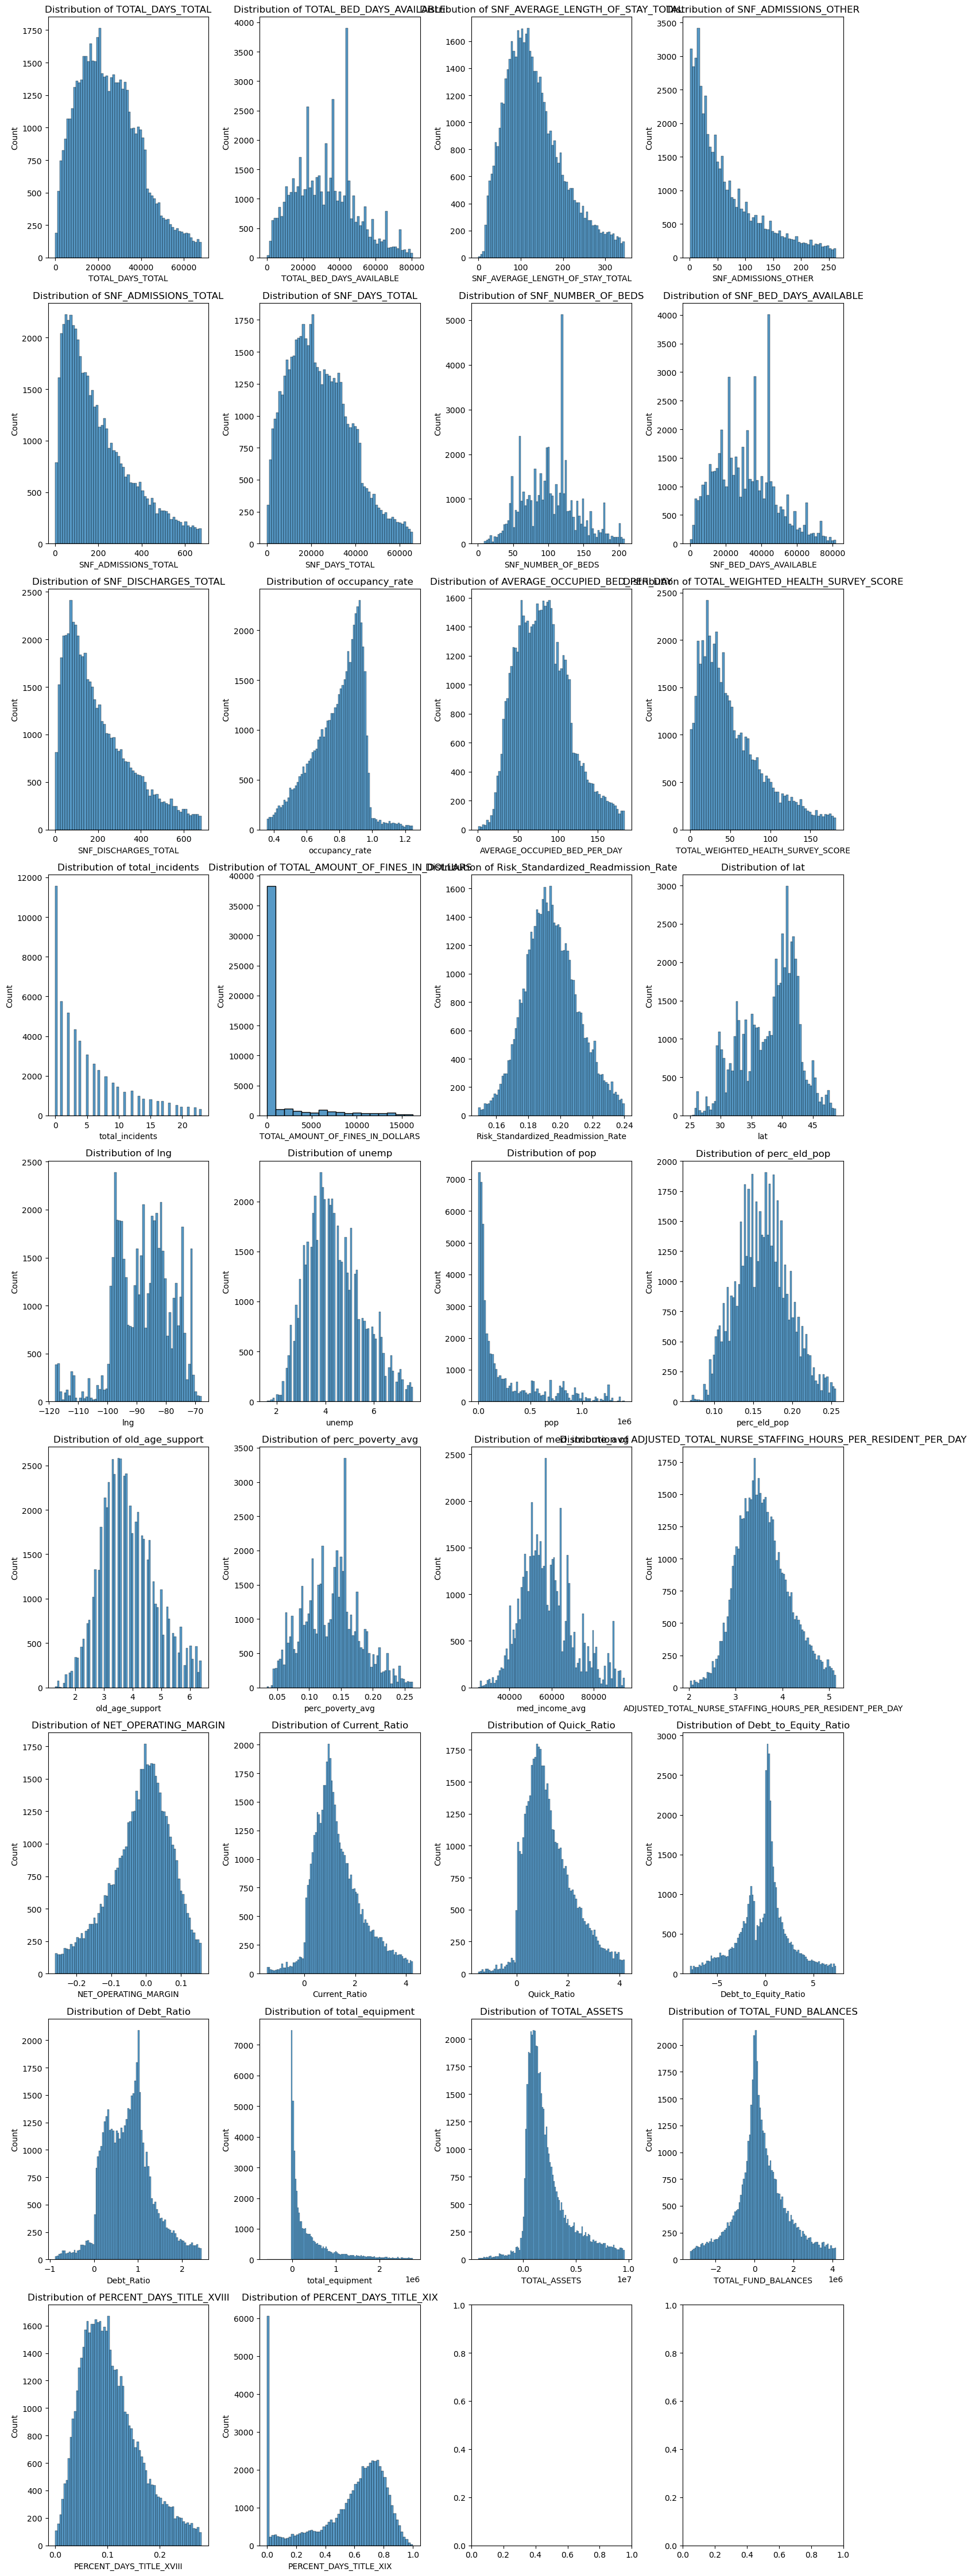

In [21]:
num_cols = len(pre_covid[continuous_cols].columns)
num_rows = (num_cols + 3) // 4  # Adjusting number of rows dynamically

fig, axes = plt.subplots(nrows=num_rows,
                         ncols=4, figsize=(15, num_rows*5))

axes = axes.flatten()

for i,col in enumerate(pre_covid[continuous_cols]): 
    
    sns.histplot(data=pre_covid, x=col,ax=axes[i])
    
    axes[i].set_title(f'Distribution of {col}')
    
    
plt.tight_layout()
    
plt.show()

Pasting list but dropping target to feed to pipeline 

In [22]:
#create last set of dummies needed before impute 
pre_covid = pd.get_dummies(pre_covid,
               columns = ['OWNERSHIP_TYPE_DETAIL',
                          'PROVIDER_CHANGED_OWNERSHIP_IN_LAST_12_MONTHS'],
               dtype=int,
               drop_first=True)

df = pre_covid #assign precovid data with imputed outliers and dummy cols to df to train and fit model

lets onehot encode nursing homes that exceeded max occupancy

* We see this is prevalent that some homes go over occupancy by up to 20%

* this could repeat in the future, lets see how it impacts model performance

In [23]:
#create "overflow" feature

df = df.assign(over_capacity = np.where(df['occupancy_rate'] > 1, df['occupancy_rate'] - 1, 0))

#replace total equipment less than 0 with 0 
df.loc[df['total_equipment'] < 0, 'total_equipment'] = 0

In [24]:
#all continuous column in dataset
continuous_cols = [
 'FISCAL_YEAR_DAYS',
 'FACIL_AGE',
 #'TYPE_OF_CONTROL', # this is categorical/nominal
       #'TOTAL_DAYS_TITLE_XVIII', 
       #'TOTAL_DAYS_TITLE_XIX', 
       #'TOTAL_DAYS_OTHER',
       'TOTAL_DAYS_TOTAL', 
       'TOTAL_BED_DAYS_AVAILABLE',
       'SNF_NUMBER_OF_BEDS', # this should indicate facility size to the model 
      # 'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XVIII',
     #  'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XIX',
       'SNF_AVERAGE_LENGTH_OF_STAY_TOTAL', 
      # 'SNF_ADMISSIONS_TITLE_XVIII', 
       #'SNF_ADMISSIONS_OTHER',
       'SNF_ADMISSIONS_TOTAL',  
       #'SNF_DISCHARGES_TITLE_XVIII',
       #'SNF_DISCHARGES_TITLE_XIX', 
      # 'SNF_DISCHARGES_TITLE_OTHER',
       'SNF_DISCHARGES_TOTAL', 
       #occupancy 
       'OCCUPANCY_RATE', #relative occupancy for facilities to judge capacity 
       'AVERAGE_OCCUPIED_BED_PER_DAY', #magnitude of occupancy, another indicator of facility size
        'TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE',
        #penalties and fines 
       'total_incidents',
       'TOTAL_AMOUNT_OF_FINES_IN_DOLLARS', 
       'Risk_Standardized_Readmission_Rate',
       #economic/location
       'LAT', 'LNG', 
       'UNEMP',
       'POP',
       #staffing 
       #'ADJUSTED_NURSE_AIDE_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
       #'ADJUSTED_LPN_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
       #'ADJUSTED_RN_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
       'ADJUSTED_TOTAL_NURSE_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
          'Current_Ratio',
       'Quick_Ratio', 
       'Debt_to_Equity_Ratio', 
       'Debt_Ratio',
        'perc_eld_pop', 
      'old_age_support', 
      'perc_poverty_avg', 
      'med_income_avg',
      'total_equipment', # ppe feature
      'TOTAL_ASSETS',
      #'TOTAL_LIABILITIES',
      'TOTAL_FUND_BALANCES',
      'PERCENT_DAYS_TITLE_XVIII', 
       'PERCENT_DAYS_TITLE_XIX',
       'NET_OPERATING_MARGIN'# this is the target 
       ]


categoricals = [
 'PROVIDER_CHANGED_OWNERSHIP_IN_LAST_12_MONTHS',
 'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_FAMILY',
 'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_RESIDENT', # deemed unimportant by xgboost model 
 'RURAL_VERSUS_URBAN_U', # deemed unimportant by xgboost model 
 #ownership type 
 #'OWNERSHIP_TYPE_DETAIL_CORPORATION',
       'OWNERSHIP_TYPE_DETAIL_INDIVIDUAL',
       'OWNERSHIP_TYPE_DETAIL_LIMITED LIABILITY COMPANY',
       'OWNERSHIP_TYPE_DETAIL_PARTNERSHIP',
       'OVER_CAPACITY']


#convert cols in list and dataframe to upper (this is sloppy)

df.columns = df.columns.str.upper()

continuous_cols = [x.upper() for x in continuous_cols]


df = df[categoricals + continuous_cols]

# Construct pipeline 

Redefine continous cols as to keep it only with X array

In [25]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler,FunctionTransformer,RobustScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.pipeline import Pipeline
from feature_engine.transformation import LogCpTransformer

In [26]:

#categorical pipeline 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('VarianceThreshold',VarianceThreshold(threshold=.01))])


#specify columns to log transform here 

log_cols = ['POP',
            'TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE',
            #snf columns 
       'SNF_AVERAGE_LENGTH_OF_STAY_TOTAL',
       'SNF_ADMISSIONS_TOTAL',
       
       #discharges
       'SNF_DISCHARGES_TOTAL',
       #ppe
       #'TOTAL_EQUIPMENT',
       'TOTAL_AMOUNT_OF_FINES_IN_DOLLARS'
     ]

#log transformation 

log_transformer = LogCpTransformer(variables = log_cols)

#continuous column pipeline
numerical_transformer = Pipeline(steps=[('log_transformer',log_transformer), # log transform 
                                        ('scaler',StandardScaler())]) # scale data 

#build preprocessor to handle numericals by scaling and transforming, then impute all in pipeline
preprocessor = ColumnTransformer(transformers = [('num_transform',numerical_transformer,continuous_cols[:-1]),
                                                 ('cat_transformer',categorical_transformer,categoricals)],
                                 remainder='drop')

#preprocessing pipeline selecting variance threshold,
# impute missing values and outliers, plus scaling.
pipe = Pipeline(steps = [('preprocessor',preprocessor)])

we've observed that these "title" columns dont add nearly anything to the predictive accuracy, we dump them in turn for their "Total" counterparts.

In [27]:
from sklearn.model_selection import train_test_split

#create X and Y and split 

X = df.drop(['NET_OPERATING_MARGIN'],axis=1)

y = df[['NET_OPERATING_MARGIN']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,shuffle=True)

#perform imputation ahead of pipeline due to including log transformer

knn = KNNImputer(n_neighbors=20) #choose a higher number of neighbors than default to avoid noisy imputation

X_train = pd.DataFrame(knn.fit_transform(X_train),columns=X_train.columns)

X_test = pd.DataFrame(knn.transform(X_test),columns=X_test.columns)

#transform X 

X_train = pd.DataFrame(pipe.fit_transform(X_train))

#notice we only call transform here, we do not fit the pipeline to the test set 
X_test = pd.DataFrame(pipe.transform(X_test))

In [28]:
#get feature names from preprocessor 
feature_to_keep_list = preprocessor.get_feature_names_out().tolist()
#split on double underscore 
features_to_keep = [x.split('__')[1]  for x in feature_to_keep_list]

rename fields for interpretability 

In [29]:
X_train.columns = features_to_keep

X_test.columns = features_to_keep

# impute target and examine distribution 

In [30]:
imp = KNNImputer() 

y_train = imp.fit_transform(y_train)

y_test = imp.transform(y_test)

# visualize distribution and .describe() 

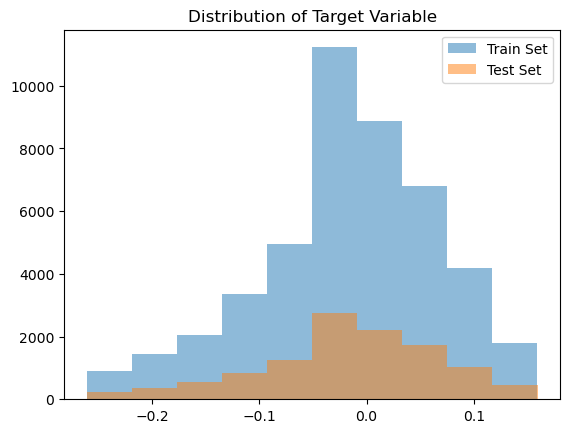

-0.260851425 0.159236299
-0.260851425 0.159362437


In [31]:

plt.hist(y_train,label='Train Set',alpha=.5)

plt.hist(y_test,label='Test Set',alpha=.5)

plt.title('Distribution of Target Variable')

plt.legend()

plt.show()

print(y_train.min(),y_train.max()) 

print(y_test.min(),y_test.max())

In [32]:
# Quickly test lots of models 

def train_models(X_train, X_test,y_train,y_test, model_dict):

    from sklearn.linear_model import Ridge,ElasticNet,Lasso
    from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,HistGradientBoostingRegressor
    from xgboost import XGBRegressor
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,mean_squared_log_error
    from sklearn.model_selection import train_test_split

    models = model_dict

    for model_name, model in models.items():
        
        model.fit(X_train, y_train)  # train models
        
        # Make Predictions
        y_train_preds = model.predict(X_train)
        y_test_preds = model.predict(X_test)
        
        # Training Set Performance
        model_r2_train = r2_score(y_train, y_train_preds)
        model_r2_test = r2_score(y_test, y_test_preds)
        
        model_rmse_train = np.sqrt(mean_squared_error(y_train, y_train_preds))
        model_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_preds))
        
        
        model_mae_train = mean_absolute_error(y_train, y_train_preds)
        model_mae_test = mean_absolute_error(y_test, y_test_preds)
        
        # Print results with model name
        print(f"\nPerformance for {model_name} Model:")
        print("Training Set Performance:")
        print(f"  R^2 Score (Training): {model_r2_train:.4f}")
        print(f"  Root Mean Squared Error (Training): {model_rmse_train:.4f}")
        print(f"  Mean Absolute Error (Training): {model_mae_train:.4f}")

        print("\nTesting Set Performance:")
        print(f"   R^2 Score (Testing): {model_r2_test:.4f}")
        print(f"   Root Mean Squared Error (Testing): {model_rmse_test:.4f}")
        print(f"   Mean Absolute Error (Testing): {model_mae_test:.4f}")

Engineer Regional Cluster on longitude and latitude

from sklearn.cluster import KMeans 

#score clusters 

from sklearn.metrics import silhouette_score

# Specifying the range of clusters to test
max_clusters = 6
silhouette_scores = []

for n_clusters in range(2, max_clusters + 1):
    # Creating KMeans instance
    kmeans = KMeans(n_clusters=n_clusters)
    # Fitting the model
    vars_to_cluster = ['LAT','LNG','SNF_ADMISSIONS_TOTAL','SNF_DISCHARGES_TOTAL']
    kmeans.fit(X_train[vars_to_cluster])
    # Appending the sum of squared distances to list
    silhouette_scores.append(silhouette_score(X_train[vars_to_cluster],
                                              kmeans.labels_))

# Plotting the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Elbow Plot')
plt.xlabel('N Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Score features using f-regression to look at potential clustering opportunities

In [33]:
from sklearn.feature_selection import SelectKBest,f_regression, mutual_info_regression
#kbest (F Regression Scores)
kbest = SelectKBest(score_func=f_regression,k=len(X_train.columns))

bestk_feats = kbest.fit_transform(X_train,y_train)

selected = kbest.get_support(indices=True) 

kseries = pd.Series(kbest.scores_,index = X_train.loc[selected].columns)

kseries.sort_values(ascending=False)


/Users/jack/tensorflow-test/env/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


DEBT_TO_EQUITY_RATIO                                        4121.999293
TOTAL_FUND_BALANCES                                         3983.015990
DEBT_RATIO                                                  3513.773764
CURRENT_RATIO                                               2879.479595
OCCUPANCY_RATE                                              2075.170773
QUICK_RATIO                                                 1764.178091
TOTAL_DAYS_TOTAL                                             759.230253
TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE                           707.088787
TOTAL_ASSETS                                                 639.150132
PERCENT_DAYS_TITLE_XVIII                                     607.549177
AVERAGE_OCCUPIED_BED_PER_DAY                                 586.433654
TOTAL_INCIDENTS                                              523.773792
TOTAL_AMOUNT_OF_FINES_IN_DOLLARS                             355.739627
FISCAL_YEAR_DAYS                                             276


# Specifying the number of clusters
n_clusters = 3

# Creating KMeans instance
kmeans = KMeans(n_clusters=n_clusters)

# Fitting the model
kmeans.fit(X_train[vars_to_cluster])

# Getting the cluster centers and labels
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

#assign clusters to data 

X_train['regional_clusters'] = cluster_labels #assign train labels to train set 

X_test['regional_clusters'] = kmeans.predict(X_test[vars_to_cluster]) # predict on test set

In [34]:

#define models to test 

from sklearn.linear_model import Lasso, Ridge,LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR 
from sklearn.neighbors import KNeighborsRegressor

model_dict = {'Lasso':Lasso(),
              'Ridge':Ridge(),
              'KNN':KNeighborsRegressor(n_neighbors=10),
              'Random Forest':RandomForestRegressor(max_depth=4),
              'Gradient Boosted Regressor':GradientBoostingRegressor(max_depth=3),
              'XGBOOST':XGBRegressor(max_depth=3),
              'Linear':LinearRegression(),
              'DecisionTreeRegressor':DecisionTreeRegressor(max_depth=8)}

train_models(X_train,X_test,y_train,y_test,model_dict=model_dict)


Performance for Lasso Model:
Training Set Performance:
  R^2 Score (Training): 0.0000
  Root Mean Squared Error (Training): 0.0831
  Mean Absolute Error (Training): 0.0633

Testing Set Performance:
   R^2 Score (Testing): -0.0000
   Root Mean Squared Error (Testing): 0.0833
   Mean Absolute Error (Testing): 0.0637

Performance for Ridge Model:
Training Set Performance:
  R^2 Score (Training): 0.2031
  Root Mean Squared Error (Training): 0.0742
  Mean Absolute Error (Training): 0.0573

Testing Set Performance:
   R^2 Score (Testing): 0.2076
   Root Mean Squared Error (Testing): 0.0742
   Mean Absolute Error (Testing): 0.0574

Performance for KNN Model:
Training Set Performance:
  R^2 Score (Training): 0.4799
  Root Mean Squared Error (Training): 0.0599
  Mean Absolute Error (Training): 0.0457

Testing Set Performance:
   R^2 Score (Testing): 0.3637
   Root Mean Squared Error (Testing): 0.0665
   Mean Absolute Error (Testing): 0.0508


/Users/jack/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Performance for Random Forest Model:
Training Set Performance:
  R^2 Score (Training): 0.2260
  Root Mean Squared Error (Training): 0.0731
  Mean Absolute Error (Training): 0.0563

Testing Set Performance:
   R^2 Score (Testing): 0.2251
   Root Mean Squared Error (Testing): 0.0733
   Mean Absolute Error (Testing): 0.0565


/Users/jack/tensorflow-test/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Performance for Gradient Boosted Regressor Model:
Training Set Performance:
  R^2 Score (Training): 0.3125
  Root Mean Squared Error (Training): 0.0689
  Mean Absolute Error (Training): 0.0530

Testing Set Performance:
   R^2 Score (Testing): 0.3013
   Root Mean Squared Error (Testing): 0.0697
   Mean Absolute Error (Testing): 0.0537

Performance for XGBOOST Model:
Training Set Performance:
  R^2 Score (Training): 0.3803
  Root Mean Squared Error (Training): 0.0654
  Mean Absolute Error (Training): 0.0505

Testing Set Performance:
   R^2 Score (Testing): 0.3478
   Root Mean Squared Error (Testing): 0.0673
   Mean Absolute Error (Testing): 0.0521

Performance for Linear Model:
Training Set Performance:
  R^2 Score (Training): 0.2031
  Root Mean Squared Error (Training): 0.0742
  Mean Absolute Error (Training): 0.0573

Testing Set Performance:
   R^2 Score (Testing): 0.2076
   Root Mean Squared Error (Testing): 0.0742
   Mean Absolute Error (Testing): 0.0574

Performance for DecisionTre

# Lets fit a linear model with our new features

In [35]:
#kbest (F Regression Scores)
kbest = SelectKBest(score_func=f_regression,k=18)

bestk_feats = kbest.fit_transform(X_train,y_train)

selected = kbest.get_support(indices=True) 

kseries = pd.Series(kbest.scores_,index = X_train.loc[selected].columns)

print('Top 20 Features')

k_25 = kseries.sort_values(ascending=False)[:25]

Top 20 Features


/Users/jack/tensorflow-test/env/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
linear_model = Ridge()

linear_model.fit(X_train[k_25.index],y_train)

Ridge()

In [37]:
coefs = pd.Series(linear_model.coef_.flatten(),index=X_train[k_25.index].columns)

coefs = coefs.sort_values(ascending=False,key=lambda x: abs(x))

coefs

DEBT_TO_EQUITY_RATIO                                        0.013891
TOTAL_BED_DAYS_AVAILABLE                                   -0.013804
TOTAL_DAYS_TOTAL                                            0.011945
TOTAL_FUND_BALANCES                                         0.009587
CURRENT_RATIO                                               0.008869
PERCENT_DAYS_TITLE_XVIII                                    0.007883
OCCUPANCY_RATE                                              0.007416
DEBT_RATIO                                                 -0.006904
SNF_ADMISSIONS_TOTAL                                       -0.006466
FISCAL_YEAR_DAYS                                            0.006417
LAT                                                        -0.005021
SNF_AVERAGE_LENGTH_OF_STAY_TOTAL                            0.003909
ADJUSTED_TOTAL_NURSE_STAFFING_HOURS_PER_RESIDENT_PER_DAY   -0.003851
SNF_DISCHARGES_TOTAL                                        0.002919
TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE

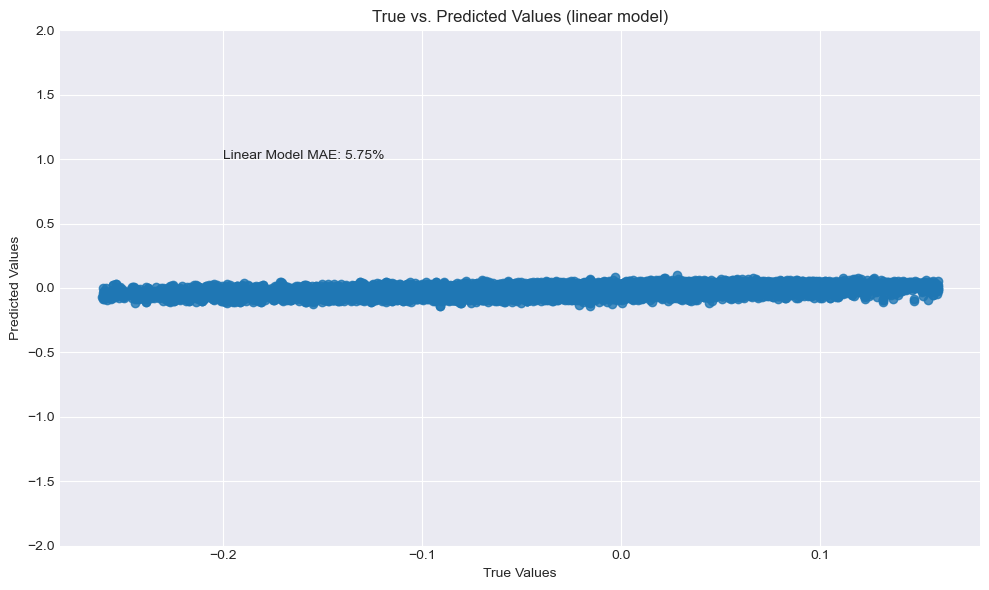

In [38]:
#plot linear model results 
plt.style.use('seaborn-v0_8-dark')
# import mae function 
from sklearn.metrics import mean_absolute_error 


y_true = y_test.flatten()

y_pred = linear_model.predict(X_test[k_25.index])

linear_mae = mean_absolute_error(y_true,y_pred)

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(10,6))

sns.regplot(x=y_true, y=y_pred,ax=ax,lowess=True)
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
ax.tick_params(axis='both')
ax.set_title('True vs. Predicted Values (linear model)')
ax.set_ylim([-2,2])
ax.text(x=-.2,y=1,s = f'Linear Model MAE: {linear_mae * 100:.2f}%')

plt.grid(True)

plt.tight_layout()


import xgboost as xgb

params = {
    'objective': 'reg:squarederror',
    'eta':.25,
    'eval_metric': 'mae', # optimize for MAE
    'max_depth': 5,  # Maximum depth of tree (example value)
    'subsample': 1,  # Subsample ratio of the training instances (example value)
    'colsample_bytree': 1,  # Subsample ratio of columns (example value)
    'random_state': 42
}
    
dtrain = xgb.DMatrix(X_train[k_25.index],label=y_train)
    
dtest = xgb.DMatrix(X_test[k_25.index],label=y_test) 
    
model = xgb.train(dtrain = dtrain,params=params,
                      num_boost_round = 1000,
                      early_stopping_rounds=10,
                      evals=[(dtrain,'train_set'),(dtest,'eval_set')],
                      verbose_eval=True)

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Define the parameter grid for the randomized search
param_grid = {
    'colsample_bytree': [0.7, 0.8,.9],  # Subsample ratio of columns
    'reg_alpha': np.arange(0, 0.5, 0.05),  # L1 regularization term on weights
    'reg_lambda': np.arange(0, 0.5, 0.05),  # L2 regularization term on weights
    'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3],  # Learning rate
    'max_depth': [3, 4, 5, 6, 7],  # Maximum depth of the tree
    'min_child_weight': [1, 2, 3, 4, 5],  # Minimum sum of instance weight needed in a child
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'subsample': [0.6, 0.7, 0.8, 0.9],  # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],  # Subsample ratio of columns
}

best_num_trees = 600

# Instantiate XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                             random_state=42,
                             n_estimators=best_num_trees)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='neg_mean_absolute_error',  # Use negative MAE as the scoring metric
    cv=5,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = random_search.best_params_
best_score = random_search.best_score_


# Define a finer grid around the best parameters found by randomized search
finer_param_grid = {
    'colsample_bytree': [best_params['colsample_bytree'] - 0.05, best_params['colsample_bytree'], best_params['colsample_bytree'] + 0.05],
    'reg_alpha': [best_params['reg_alpha'] - 0.02, best_params['reg_alpha'], best_params['reg_alpha'] + 0.02],
    'reg_lambda': [best_params['reg_lambda'] - 0.02, best_params['reg_lambda'], best_params['reg_lambda'] + 0.02],
    'learning_rate': [best_params['learning_rate'] - 0.05, best_params['learning_rate'], best_params['learning_rate'] + 0.05],
    'max_depth': [best_params['max_depth']],
    'min_child_weight': [best_params['min_child_weight']],
    'gamma': [best_params['gamma']],
    'subsample': [best_params['subsample']],
}

# Initialize XGBRegressor with the best number of trees found
xgb_model_finer = xgb.XGBRegressor(objective='reg:squarederror',
                                   random_state=42,
                                   n_estimators=best_num_trees)

# Initialize GridSearchCV
grid_search_finer = GridSearchCV(
    estimator=xgb_model_finer,
    param_grid=finer_param_grid,
    scoring='neg_mean_absolute_error',  # Use negative MAE as the scoring metric
    cv=2,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Fit the model with finer grid search
grid_search_finer.fit(X_train, y_train)

# Get the best parameters and the best score
best_params_finer = grid_search_finer.best_params_
best_score_finer = grid_search_finer.best_score_

print("Best parameters found with finer grid search:", best_params_finer)
print("Best MAE score found with finer grid search:", -best_score_finer)


# fitting model with best params 

In [39]:
best_params_finer = {'colsample_bytree': 0.75, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7,
                     'min_child_weight': 1, 'reg_alpha': 0.18000000000000002, 
                     'reg_lambda': 0.07, 'subsample': 0.9}


#Best MAE score found with finer grid search (5x2 fold CV): 0.04811764113693685


best_num_trees = 475

xgb_final = XGBRegressor(objective='reg:squarederror',
                             random_state=42,
                             **best_params_finer,
                             n_estimators = best_num_trees)


xgb_final.fit(X_train[k_25.index],y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=475, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

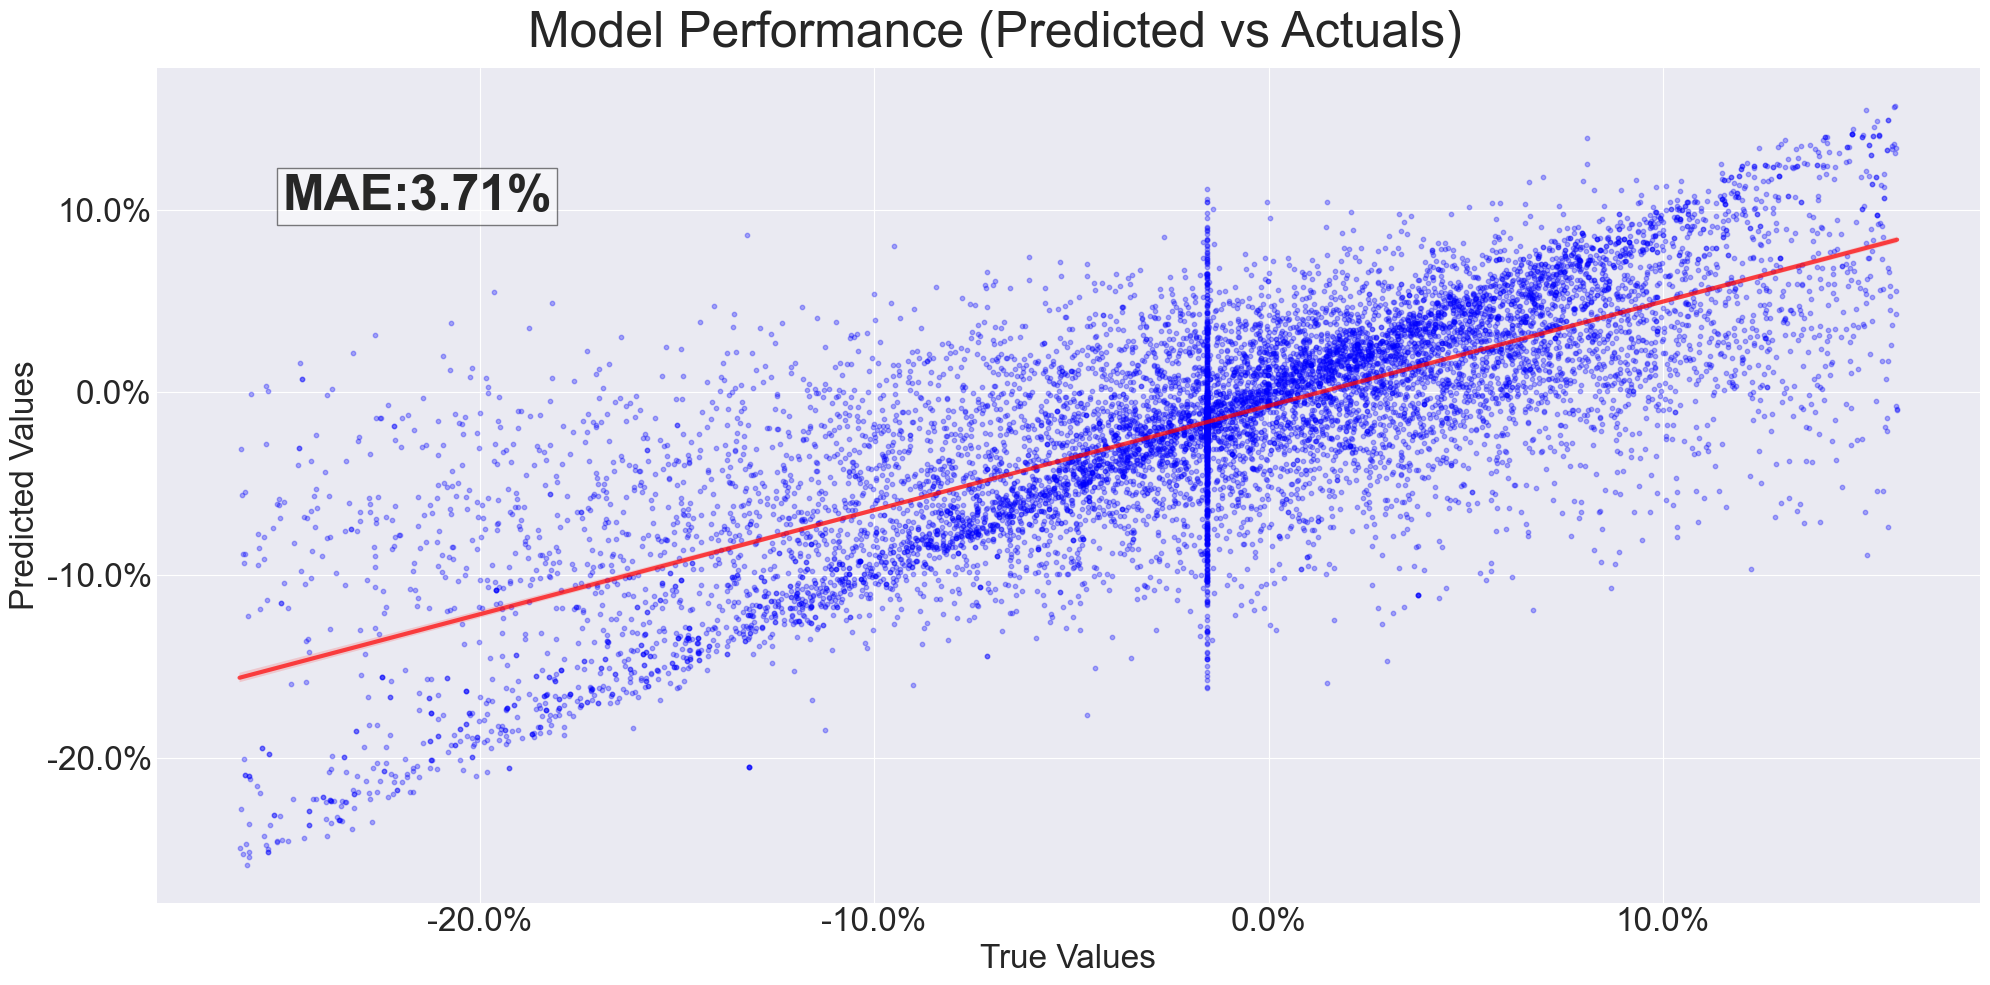

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error 

y_true = y_test.flatten()

y_pred = xgb_final.predict(X_test[k_25.index])

mae_xgb = mean_absolute_error(y_true,y_pred)

fig, ax = plt.subplots(figsize=(20,10))

sns.regplot(x=y_true,
            y=y_pred,
            ax=ax, 
            scatter_kws={'s':10,
                         'alpha':0.3,
                         'color':'blue'},
            line_kws={'lw':3,
                      'color':'red',
                      'alpha':.7},
            ci=90)

#set labels and print score on plot 
ax.set_xlabel('True Values',fontsize=24)
ax.set_ylabel('Predicted Values',fontsize=24)
ax.tick_params(axis='both', labelsize=24)
ax.text(x=-0.25,
           y=.1,
           s=f'MAE:{(mae_xgb * 100):.2f}%',
          fontsize=36,
          fontweight='bold',
          bbox=dict(facecolor='white',
                    alpha=.5))

#set title and grids on plots
fig.suptitle('Model Performance (Predicted vs Actuals)',fontsize=36)
ax.grid(True)

from matplotlib.ticker import FuncFormatter

def percent_formatter(x,pos): 
    return '{:.1%}'.format(x)

ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax.xaxis.set_major_formatter(FuncFormatter(percent_formatter))

fig.tight_layout()


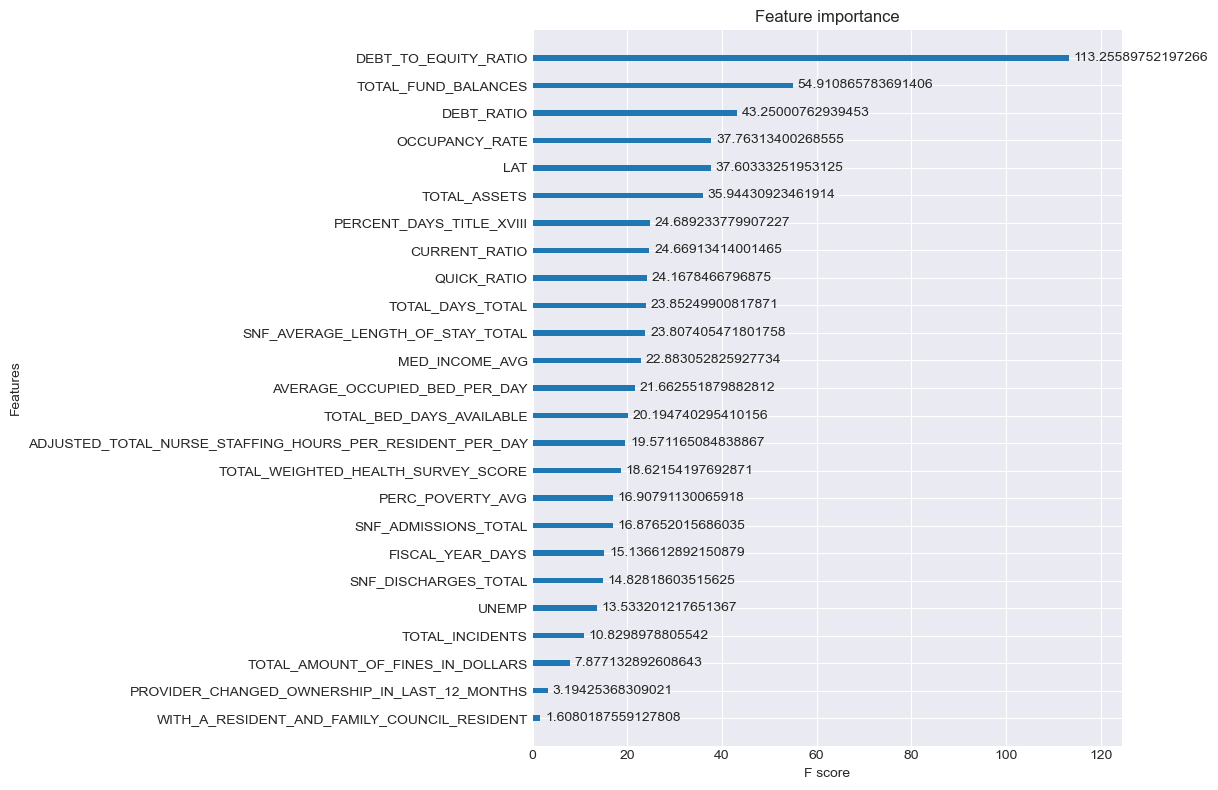

In [41]:
plt.rc('figure',figsize=(12,8))
import xgboost as xgb 

xgb.plot_importance(xgb_final,
                    importance_type='total_gain')

plt.tight_layout()

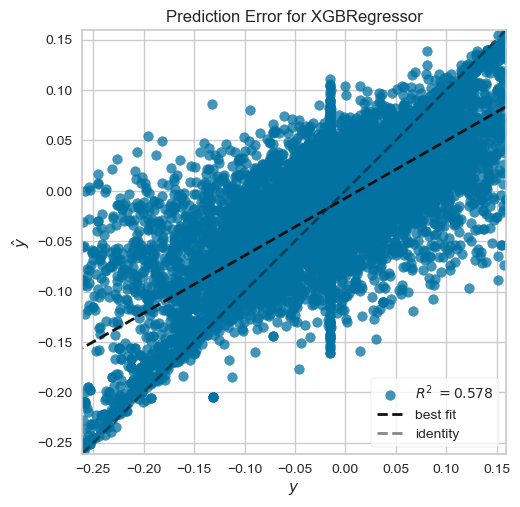

<Axes: title={'center': 'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [42]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot, PredictionError, CooksDistance, AlphaSelection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

# Prediction Error Plot
prediction_error = PredictionError(xgb_final)
prediction_error.score(X_test[k_25.index], y_true)
prediction_error.show()


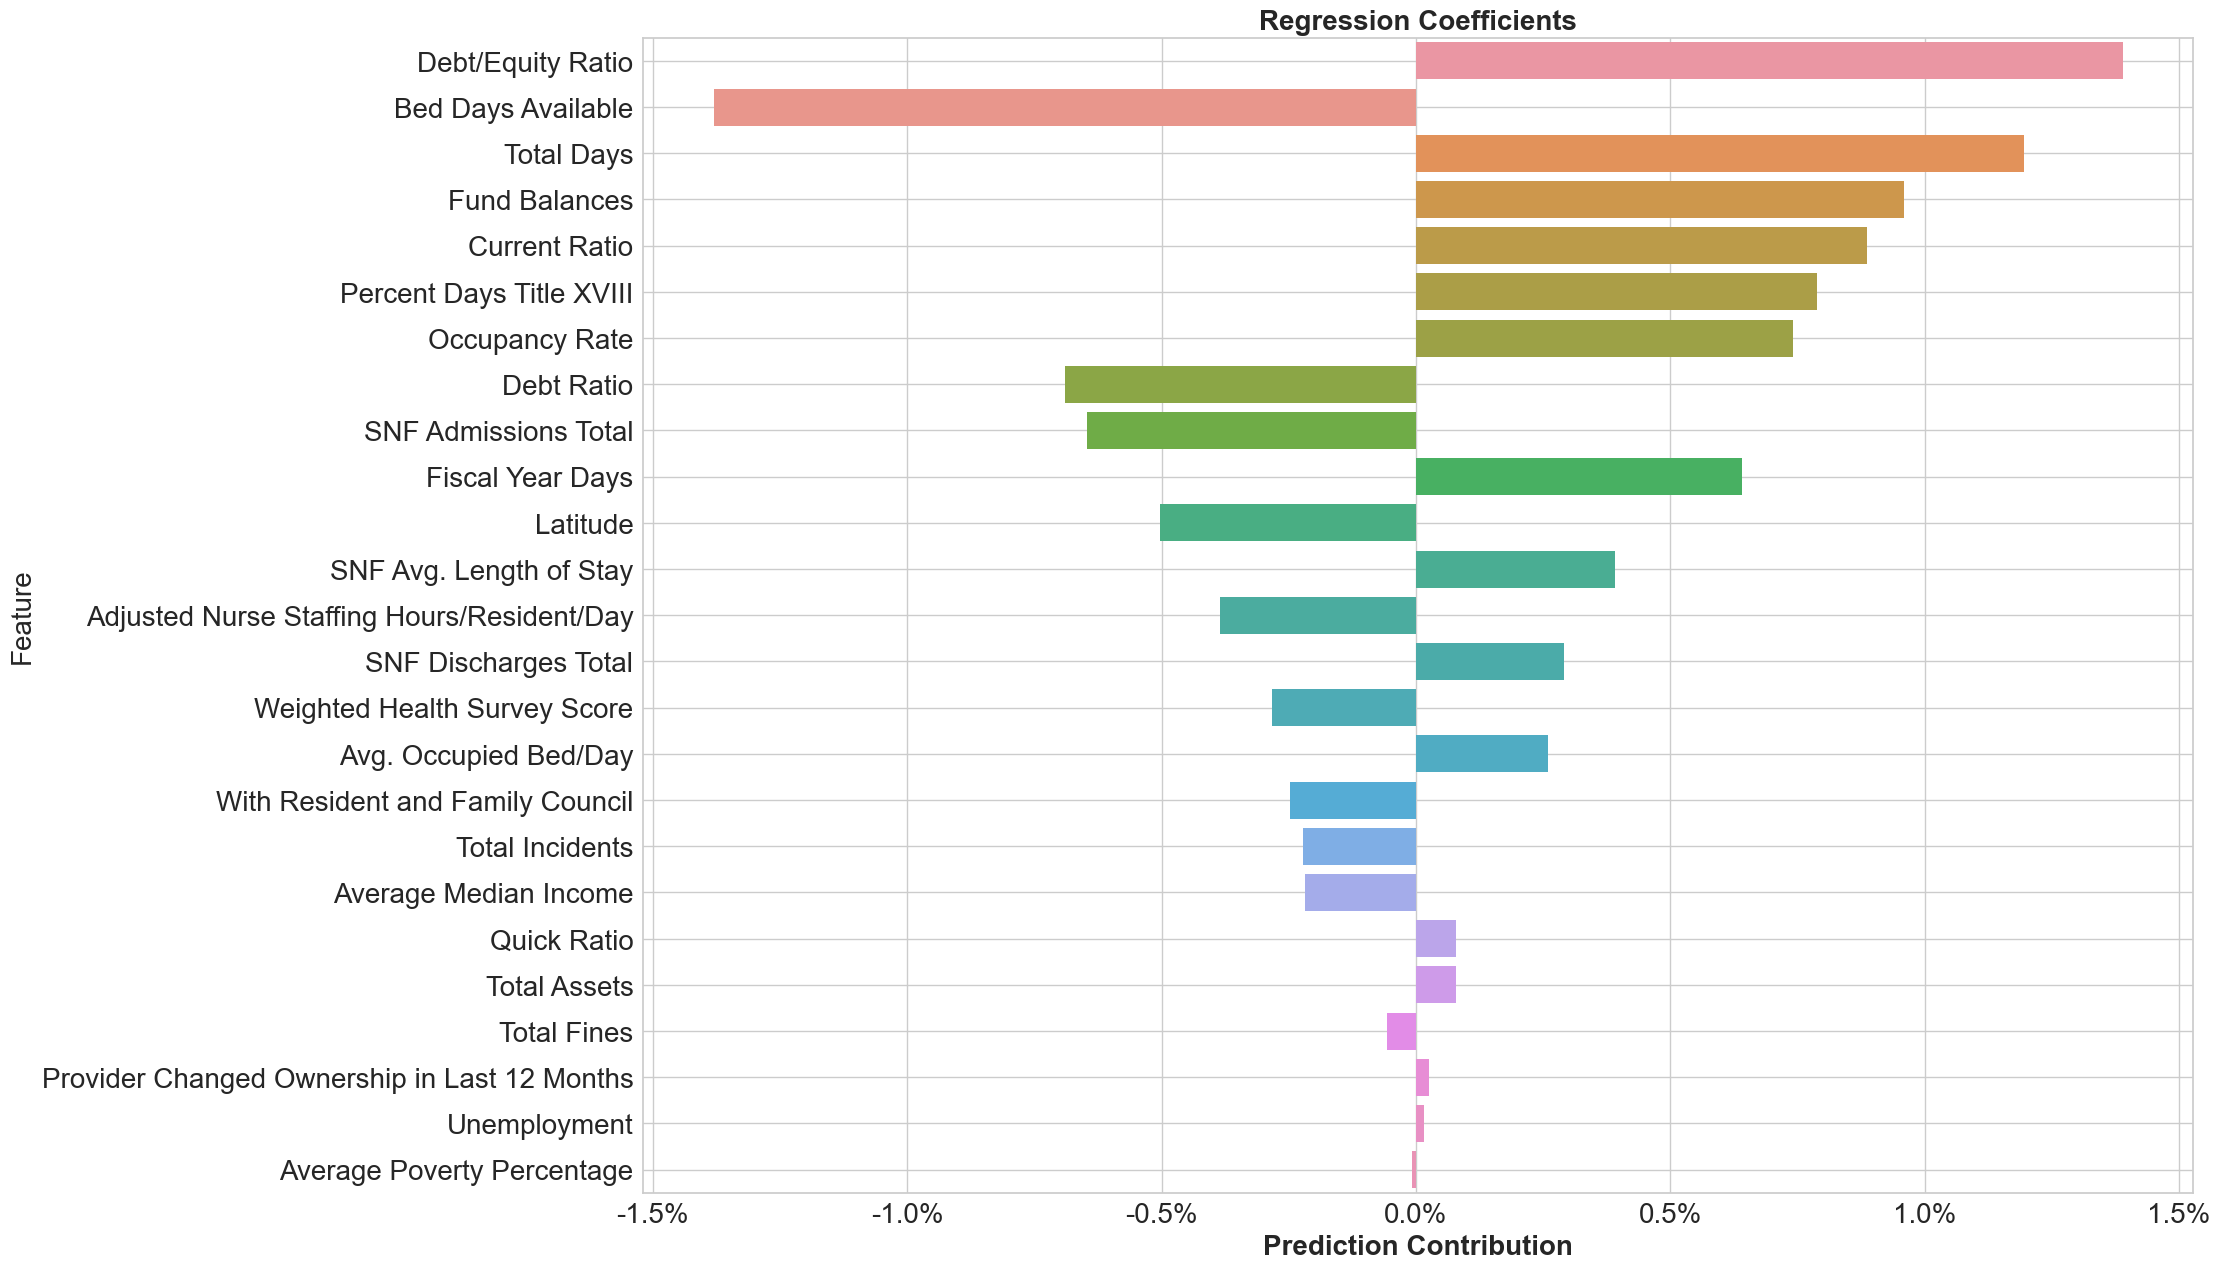

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Your dictionary mapping feature names to shorter versions
feature_code_map = {
    'DEBT_TO_EQUITY_RATIO': 'Debt/Equity Ratio',
    'TOTAL_BED_DAYS_AVAILABLE': 'Bed Days Available',
    'TOTAL_DAYS_TOTAL': 'Total Days',
    'TOTAL_FUND_BALANCES': 'Fund Balances',
    'CURRENT_RATIO': 'Current Ratio',
    'PERCENT_DAYS_TITLE_XVIII': 'Percent Days Title XVIII',
    'OCCUPANCY_RATE': 'Occupancy Rate',
    'DEBT_RATIO': 'Debt Ratio',
    'SNF_ADMISSIONS_TOTAL': 'SNF Admissions Total',
    'FISCAL_YEAR_DAYS': 'Fiscal Year Days',
    'LAT': 'Latitude',
    'SNF_AVERAGE_LENGTH_OF_STAY_TOTAL': 'SNF Avg. Length of Stay',
    'ADJUSTED_TOTAL_NURSE_STAFFING_HOURS_PER_RESIDENT_PER_DAY': 'Adjusted Nurse Staffing Hours/Resident/Day',
    'SNF_DISCHARGES_TOTAL': 'SNF Discharges Total',
    'TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE': 'Weighted Health Survey Score',
    'AVERAGE_OCCUPIED_BED_PER_DAY': 'Avg. Occupied Bed/Day',
    'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_RESIDENT': 'With Resident and Family Council',
    'TOTAL_INCIDENTS': 'Total Incidents',
    'MED_INCOME_AVG': 'Average Median Income',
    'QUICK_RATIO': 'Quick Ratio',
    'TOTAL_ASSETS': 'Total Assets',
    'TOTAL_AMOUNT_OF_FINES_IN_DOLLARS': 'Total Fines',
    'PROVIDER_CHANGED_OWNERSHIP_IN_LAST_12_MONTHS': 'Provider Changed Ownership in Last 12 Months',
    'UNEMP': 'Unemployment',
    'PERC_POVERTY_AVG': 'Average Poverty Percentage'
}

# Assuming coef is your DataFrame containing regression coefficients
# Replace coef.index with the mapped names using feature_code_map
coef = pd.DataFrame(coefs, columns=['Regression Coefficient'])

fig, ax = plt.subplots(figsize=(20, 15))

sns.barplot(data=coef, y=[feature_code_map.get(feature, feature) for feature in coef.index],
            x='Regression Coefficient', orient='h', ax=ax, dodge=True)

plt.title('Regression Coefficients', fontsize=20, fontweight='bold')
plt.xlabel('Prediction Contribution', fontsize=20, fontweight='bold')
plt.ylabel('Feature', fontsize=20)

# Format as percentage
def percent_formatter(x, pos): 
    return '{:.1%}'.format(x)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.grid(True)

plt.show()


In [44]:
linear_coefs = pd.DataFrame((coefs * 100).round(2),columns=['Percentage Contribution'])

linear_coefs

,Percentage Contribution
DEBT_TO_EQUITY_RATIO,1.39
TOTAL_BED_DAYS_AVAILABLE,-1.38
TOTAL_DAYS_TOTAL,1.19
TOTAL_FUND_BALANCES,0.96
CURRENT_RATIO,0.89
PERCENT_DAYS_TITLE_XVIII,0.79
OCCUPANCY_RATE,0.74
DEBT_RATIO,-0.69
SNF_ADMISSIONS_TOTAL,-0.65
FISCAL_YEAR_DAYS,0.64


In [45]:
from sklearn.feature_selection import SelectKBest,f_regression, mutual_info_regression

In [46]:
df[k_25.index].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56990 entries, 0 to 56989
Data columns (total 25 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   DEBT_TO_EQUITY_RATIO                                      46106 non-null  float64
 1   TOTAL_FUND_BALANCES                                       47425 non-null  float64
 2   DEBT_RATIO                                                50515 non-null  float64
 3   CURRENT_RATIO                                             50764 non-null  float64
 4   OCCUPANCY_RATE                                            53280 non-null  float64
 5   QUICK_RATIO                                               50277 non-null  float64
 6   TOTAL_DAYS_TOTAL                                          55221 non-null  float64
 7   TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE                        52204 non-null  float64
 8   TOTAL_ASSETS    

In [47]:
#tree based importances 
feature_importances = list(xgb_final.feature_importances_)

feat_importance = pd.Series(feature_importances,index=xgb_final.feature_names_in_)

#kbest (F Regression Scores)
kbest = SelectKBest(score_func=f_regression,k=len(X_train.columns))

bestk_feats = kbest.fit_transform(X_train,y_train)

selected = kbest.get_support(indices=True) 

kseries = pd.Series(kbest.scores_,index = X_train.loc[selected].columns)

/Users/jack/tensorflow-test/env/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
#utilize mutual information on all of X for explanatory analysis  

mut_info = mutual_info_regression(X_train,y_train)


mut_series = pd.Series(mut_info,index=X_train.columns)

/Users/jack/tensorflow-test/env/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


concatenate all feature series together to get dataframe full of scores. 

In [49]:

#mutual info regression index to upper 

scores = pd.concat([feat_importance,kseries,mut_series],axis=1,join='inner')

scores.columns = ['xgb_importances','F_score','information_gain']

scores = scores.assign(avg_score = scores.mean(axis=1))

feats = scores.sort_values(by='avg_score',ascending=False)

display(feats)

,xgb_importances,F_score,information_gain,avg_score
DEBT_TO_EQUITY_RATIO,0.147270,4121.999293,1.533118,1374.559893
TOTAL_FUND_BALANCES,0.066922,3983.015990,1.549207,1328.210707
DEBT_RATIO,0.052733,3513.773764,1.548777,1171.791758
CURRENT_RATIO,0.032510,2879.479595,1.516506,960.342870
OCCUPANCY_RATE,0.043571,2075.170773,1.504545,692.239629
QUICK_RATIO,0.031542,1764.178091,1.499252,588.569628
TOTAL_DAYS_TOTAL,0.033209,759.230253,1.457716,253.573726
TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE,0.025065,707.088787,1.025516,236.046456
TOTAL_ASSETS,0.044379,639.150132,1.490871,213.561794
PERCENT_DAYS_TITLE_XVIII,0.029114,607.549177,1.473590,203.017294
